### **Building Predictive Models with Machine Learning and Python**

This notebook contains Implementaion of Various Machine Learning algorithms and comparision of their perormances.

**Input Data:** Cleaned and pre-processed files from Feature engineering session are used as input.

    x_train.csv, x_test.csv, y_train.csv, y_test.csv
    Location --> content/04_data_preprocessing_&_feature_engineering/Solution_Classification_preprocessing.ipynb
    
**Some insights about the features**

*LIMIT_BAL:* Amount of given credit in NT dollars <br>
*SEX:* Gender (1=male, 2=female)<br>
*EDUCATION:* (1=graduate school, 2=university, 3=high school, 4=others)<br>
*MARRIAGE:* Marital status (1=married, 2=single, 3=others)<br>
*AGE:* Age in years<br>
*PAY_0:* Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)<br>
*PAY_2 - PAY_6:* Repayment status in August to April, 2005 (scale same as above)<br>
*BILL_AMT1 - BILL_AMT6:* Amount of bill statement from September to April, 2005 <br>
*PAY_AMT1 - PAY_AMT6:* Amount of previous payment from September to April, 2005 (NT dollar)<br>
*default.payment.next.month:* Default payment (1=yes, 0=no)

##### Importing required libraries

In [1]:
#importing required libraries for data analysis
import pandas as pd
import numpy as np

#Visuals and Time libraries
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')

#Import Data balancing libraries
import imblearn
from imblearn.over_sampling import SMOTE

# Import models from sklearn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Import evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
# Read the training & test datasets generated from Preprocessed classification Solution 
# Link --> content/04_data_preprocessing_&_feature_engineering/Solution_Classification_preprocessing.ipynb

x_train=pd.read_csv('../datasets/classification/processed/X_train.csv', index_col=0)
x_test=pd.read_csv('../datasets/classification/processed/X_test.csv', index_col=0)

y_train=pd.read_csv('../datasets/classification/processed/y_train.csv', index_col=0)
y_test=pd.read_csv('../datasets/classification/processed/y_test.csv', index_col=0)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(20659, 19) (8984, 19) (20659, 1) (8984, 1)


### Data Balancing

All resampling operations are applied to only training datasets. If upsampling is done before splitting the dataset into a train and validation set, then it could end up with the same observation in both datasets. As a result, a machine learning model will be able to perfectly predict the value for those observations when predicting on the validation set, hence inflating the accuracy and recall.

A. Under Sampling:

    1. Random undersampling --> rus =  RandomUnderSampler()
    2. Tomek Link --> tk = TomekLinks()

B. Over Sampling:
    
    3. Random oversampling  --> ros =  RandomOverSampler()
    4. SMOTE (Synthetic Minority Over-Sampling Technique) --> sm = SMOTE()
    5. ADASYN (Adaptive Synthetic Sampling) --> adasyn =  ADASYN()

C. Hybrid Sampling:

    6. SMOTE+Tomek link --> smtom =  SMOTETomek()

In [3]:
#importing SMOTE to handle class imbalance
from imblearn.combine import SMOTETomek

smoteTomek = SMOTETomek()

# fit predictor and target variable
x_smote, y_smote = smoteTomek.fit_resample(x_train, y_train)

print('Original unbalanced dataset shape', len(y_train))
print('Resampled balanced dataset shape', len(y_smote))

Original unbalanced dataset shape 20659
Resampled balanced dataset shape 30846


#### 1. **Logistic Regression Model**

In [4]:
# Importing the Logistic Regression Model
start = time.time()
logmodel = LogisticRegression(random_state=1)
logmodel.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = logmodel.predict(x_test)
y_train_pred = logmodel.predict(x_smote)

In [5]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[3529 3456]
 [ 526 1473]]


In [6]:
#getting all scores for Logistic Regression
log_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
log_acc = round(accuracy_score(y_pred,y_test), 3)
log_prec = round(precision_score(y_pred,y_test), 3)
log_rec = round(recall_score(y_pred,y_test), 3)
log_f1 = round(f1_score(y_pred,y_test), 3)
log_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature co-efficients (Coef_ - Is generally not a great representaion of feature importance)
ft_imp = pd.DataFrame(data={'Attribute': x_smote.columns,'Importance': logmodel.coef_[0]}).sort_values(by='Importance', ascending=False)
log_feat = np.array(ft_imp['Attribute'][:3:])

#Training time calculation
log_time=stop-start

#Overall scores
results = pd.DataFrame([['Logistic Regression', log_acctr, log_acc, log_prec, log_rec, log_f1, log_roc, log_time, log_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Logistic Regression,0.633,0.557,0.737,0.299,0.425,0.585,0.301586,"[AGE_median, PAY_0, PAY_2]"


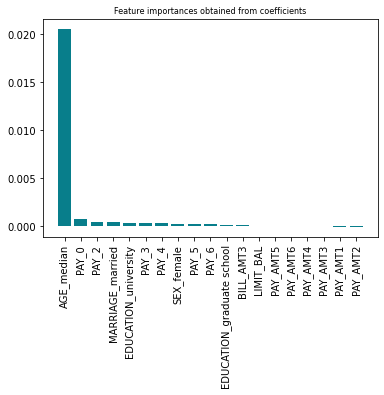

In [7]:
plt.bar(x=ft_imp['Attribute'], height=ft_imp['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=8)
plt.xticks(rotation='vertical')
plt.show()

#### 2. **KNN classifier algorithm**

In [8]:
# Importing the KNN classifier
start = time.time()
knn = KNeighborsClassifier()
knn.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = knn.predict(x_test)
y_train_pred = knn.predict(x_smote)

In [9]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[4689 2296]
 [1023  976]]


In [10]:
#getting all scores for KNN classifier
knn_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
knn_acc = round(accuracy_score(y_pred,y_test), 3)
knn_prec = round(precision_score(y_pred,y_test), 3)
knn_rec = round(recall_score(y_pred,y_test), 3)
knn_f1 = round(f1_score(y_pred,y_test), 3)
knn_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
knn_feat = ['No coefficients available']

#Training time calculation
knn_time=stop-start

results = pd.DataFrame([['KNN classifier', knn_acctr, knn_acc, knn_prec, knn_rec, knn_f1, knn_roc, knn_time, knn_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,KNN classifier,0.853,0.631,0.488,0.298,0.37,0.56,0.008689,[No coefficients available]


#### 3. **Support Vector Machines**

In [11]:
# Importing the Naive Bayes Model
start = time.time()
svm = SVC(kernel = 'rbf', random_state = 0)
svm.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = svm.predict(x_test)
y_train_pred = svm.predict(x_smote)

In [12]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[3646 3339]
 [ 601 1398]]


In [13]:
#getting all scores for SVM Model
svm_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
svm_acc = round(accuracy_score(y_pred,y_test), 3)
svm_prec = round(precision_score(y_pred,y_test), 3)
svm_rec = round(recall_score(y_pred,y_test), 3)
svm_f1 = round(f1_score(y_pred,y_test), 3)
svm_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance - Coef_ is only available in the case of linear kernel. For Non-linear kernel we can try
#sklearn.inspection.permutation_importance method
svm_feat = ['No coefficients available']

#Training time calculation
svm_time=stop-start

results = pd.DataFrame([['Support Vector Machines', svm_acctr, svm_acc, svm_prec, svm_rec, svm_f1, svm_roc, svm_time, svm_feat]],
             columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Support Vector Machines,0.614,0.561,0.699,0.295,0.415,0.577,40.709706,[No coefficients available]


#### 4. **Naive Bayes**

In [14]:
# Importing the Naive Bayes Model
start = time.time()
nb = GaussianNB()
nb.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = nb.predict(x_test)
y_train_pred = nb.predict(x_smote)

In [15]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[3642 3343]
 [ 642 1357]]


In [16]:
#getting all scores for Naive Bayes Model
nb_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
nb_acc = round(accuracy_score(y_pred,y_test), 3)
nb_prec = round(precision_score(y_pred,y_test), 3)
nb_rec = round(recall_score(y_pred,y_test), 3)
nb_f1 = round(f1_score(y_pred,y_test), 3)
nb_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
nb_feat = ['No coefficients available']

#Training time calculation
nb_time=stop-start

results = pd.DataFrame([['Naive Bayes', nb_acctr, nb_acc, nb_prec, nb_rec, nb_f1, nb_roc, nb_time, nb_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)', 'Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Naive Bayes,0.607,0.556,0.679,0.289,0.405,0.569,0.021379,[No coefficients available]


### 4. **Decision Tree Classification**

In [17]:
#fitting data into Decision Tree Classifier
start = time.time()
dtc = DecisionTreeClassifier()
dtc.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = dtc.predict(x_test)
y_train_pred = dtc.predict(x_smote)

In [18]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[5619 1366]
 [1185  814]]


In [19]:
#getting all scores for Decision Tree Classifier
dtc_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
dtc_acc = round(accuracy_score(y_pred,y_test), 3)
dtc_prec = round(precision_score(y_pred,y_test), 3)
dtc_rec = round(recall_score(y_pred,y_test), 3)
dtc_f1 = round(f1_score(y_pred,y_test), 3)
dtc_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
imp_ft = pd.DataFrame(data={'Attribute': x_smote.columns, 'Importance': dtc.feature_importances_}).sort_values(by='Importance', ascending=False)
dtc_feat = np.array(imp_ft['Attribute'][:3:])

#Training time calculation
dtc_time=stop-start

results = pd.DataFrame([['Decision Trees', dtc_acctr, dtc_acc, dtc_prec, dtc_rec, dtc_f1, dtc_roc, dtc_time, dtc_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Decision Trees,0.999,0.716,0.407,0.373,0.39,0.6,0.401316,"[PAY_0, MARRIAGE_married, SEX_female]"


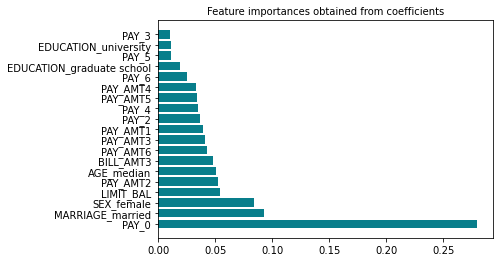

In [20]:
#Plotting feature importance
plt.barh(y=imp_ft['Attribute'], width=imp_ft['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.show()

### 5. **Random Forest Classification**

In [21]:
#fitting data into Random Forest Classifier
start = time.time()
rfc = RandomForestClassifier()
rfc.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = rfc.predict(x_test)
y_train_pred = rfc.predict(x_smote)

In [22]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[6454  531]
 [1229  770]]


In [23]:
#getting all scores for Random Forest Classifier
rfc_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
rfc_acc = round(accuracy_score(y_pred,y_test), 3)
rfc_prec = round(precision_score(y_pred,y_test), 3)
rfc_rec = round(recall_score(y_pred,y_test), 3)
rfc_f1 = round(f1_score(y_pred,y_test), 3)
rfc_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
imp_ft = pd.DataFrame(data={'Attribute': x_smote.columns, 'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
rfc_feat = np.array(imp_ft['Attribute'][:3:])

#Training time calculation

rfc_time=stop-start

results = pd.DataFrame([['Random Forest', rfc_acctr, rfc_acc, rfc_prec, rfc_rec, rfc_f1, rfc_roc, rfc_time, rfc_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'
])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Random Forest,0.999,0.804,0.385,0.592,0.467,0.716,6.842436,"[PAY_0, PAY_2, SEX_female]"


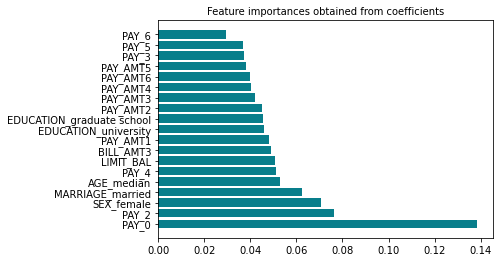

In [24]:
#Plotting feature importance
plt.barh(y=imp_ft['Attribute'], width=imp_ft['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.show()

### 6.  **Gradient Boosting**

In [25]:
#fitting data into Gradient Boosting Classifier
start = time.time()
gbc = GradientBoostingClassifier()
gbc.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = gbc.predict(x_test)
y_train_pred = gbc.predict(x_smote)

In [26]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[6486  499]
 [1200  799]]


In [27]:
#getting all scores for Logistic Regression
gbc_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
gbc_acc = round(accuracy_score(y_pred,y_test), 3)
gbc_prec = round(precision_score(y_pred,y_test), 3)
gbc_rec = round(recall_score(y_pred,y_test), 3)
gbc_f1 = round(f1_score(y_pred,y_test), 3)
gbc_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
imp_ft = pd.DataFrame(data={'Attribute': x_smote.columns, 'Importance': gbc.feature_importances_}).sort_values(by='Importance', ascending=False)
gbc_feat = np.array(imp_ft['Attribute'][:3:])

#Training time calculation
gbc_time=stop-start

results = pd.DataFrame([['Gradient Boosting', gbc_acctr, gbc_acc, gbc_prec, gbc_rec, gbc_f1, gbc_roc, gbc_time, gbc_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Gradient Boosting,0.877,0.811,0.4,0.616,0.485,0.73,7.730529,"[PAY_0, MARRIAGE_married, SEX_female]"


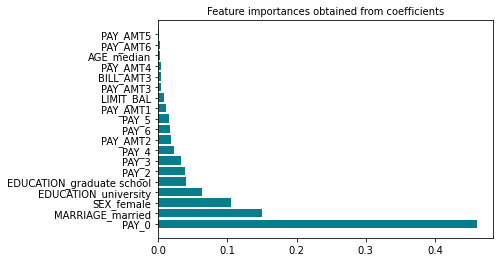

In [28]:
#Plotting feature importance
plt.barh(y=imp_ft['Attribute'], width=imp_ft['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.show()

### 7. **XG Boosting**

In [29]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[6486  499]
 [1200  799]]


In [30]:
#fitting data into XG Boosting Classifier
start = time.time()
xgb = XGBClassifier()
xgb.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = xgb.predict(x_test)
y_train_pred = xgb.predict(x_smote)

[23:20:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
#getting all scores for XG Boosting Classifier
xgb_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
xgb_acc = round(accuracy_score(y_pred,y_test), 3)
xgb_prec = round(precision_score(y_pred,y_test), 3)
xgb_rec = round(recall_score(y_pred,y_test), 3)
xgb_f1 = round(f1_score(y_pred,y_test), 3)
xgb_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
imp_ft = pd.DataFrame(data={'Attribute': x_smote.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
xgb_feat = np.array(imp_ft['Attribute'][:3:])

#Training time calculation
xgb_time=stop-start

results = pd.DataFrame([['XG Boosting', xgb_acctr, xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc, xgb_time, xgb_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,XG Boosting,0.931,0.803,0.366,0.594,0.453,0.715,1.675026,"[PAY_0, MARRIAGE_married, SEX_female]"


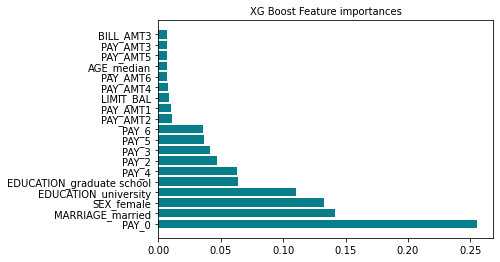

In [32]:
#Plotting feature importance
plt.barh(y=imp_ft['Attribute'], width=imp_ft['Importance'], color='#087E8B')
plt.title('XG Boost Feature importances', size=10)
plt.show()

### 8. **ADA Boosting**

In [33]:
#fitting data into Ada Boosting Classifier
start = time.time()
ada = AdaBoostClassifier()
ada.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = ada.predict(x_test)
y_train_pred = ada.predict(x_smote)

In [34]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[6455  530]
 [1260  739]]


In [35]:
#getting all scores for Ada Boosting Classifier
ada_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
ada_acc = round(accuracy_score(y_pred,y_test), 3)
ada_prec = round(precision_score(y_pred,y_test), 3)
ada_rec = round(recall_score(y_pred,y_test), 3)
ada_f1 = round(f1_score(y_pred,y_test), 3)
ada_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
imp_ft = pd.DataFrame(data={'Attribute': x_smote.columns, 'Importance': ada.feature_importances_}).sort_values(by='Importance', ascending=False)
ada_feat = np.array(imp_ft['Attribute'][:3:])

#Training time calculation
ada_time=stop-start

results = pd.DataFrame([['ADA Boosting', ada_acctr, ada_acc, ada_prec, ada_rec, ada_f1, ada_roc, ada_time, ada_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,ADA Boosting,0.861,0.801,0.37,0.582,0.452,0.71,2.200522,"[MARRIAGE_married, SEX_female, EDUCATION_unive..."


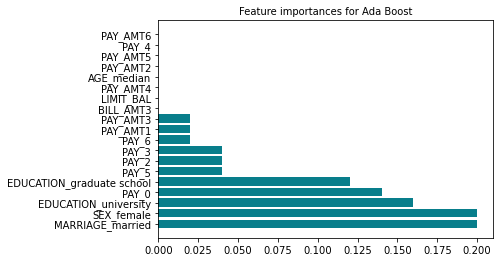

In [36]:
#Plotting feature importance
plt.barh(y=imp_ft['Attribute'], width=imp_ft['Importance'], color='#087E8B')
plt.title('Feature importances for Ada Boost', size=10)
plt.show()

### 9. **Bagging Classifier**

In [37]:
#fitting data into Bagging Classifier
start = time.time()
bag = BaggingClassifier()
bag.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = bag.predict(x_test)
y_train_pred = bag.predict(x_smote)

In [38]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[6490  495]
 [1334  665]]


In [39]:
#getting all scores for Bagging Classifier
bag_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
bag_acc = round(accuracy_score(y_pred,y_test), 3)
bag_prec = round(precision_score(y_pred,y_test), 3)
bag_rec = round(recall_score(y_pred,y_test), 3)
bag_f1 = round(f1_score(y_pred,y_test), 3)
bag_roc = round(roc_auc_score(y_pred,y_test), 3)

#Feature Importance
bag_feat = ['No coefficients available']

#Training time calculation
bag_time=stop-start

results = pd.DataFrame([['Bagging Classifier', bag_acctr, bag_acc, bag_prec, bag_rec, bag_f1, bag_roc, bag_time, bag_feat]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)','Important Features'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s),Important Features
0,Bagging Classifier,0.988,0.796,0.333,0.573,0.421,0.701,2.160669,[No coefficients available]


#### **Model Comparision**

In [40]:
all_classifiers = ['Logistic Regression', 'Support Vector Machines', 'KNN Classifier', 'Naive Bayes', 'Decision Tree', 
                   'Random Forest', 'Gradient Boosting', 'XG Boosting', 'Ada Boosting', 'Bagging algorithm']

train_accuracy =  [log_acctr, svm_acctr, knn_acctr, nb_acctr, dtc_acctr, rfc_acctr, gbc_acctr, xgb_acctr, ada_acctr, bag_acctr]
test_accuracy =   [log_acc, svm_acc, knn_acc, nb_acc, dtc_acc, rfc_acc, gbc_acc, xgb_acc, ada_acc, bag_acc]
precision_score = [log_prec, svm_prec, knn_prec, nb_prec, dtc_prec, rfc_prec, gbc_prec, xgb_prec, ada_prec, bag_prec]
recall_score =    [log_rec, svm_rec, knn_rec, nb_rec, dtc_rec, rfc_rec, gbc_rec, xgb_rec, ada_rec, bag_rec]
f1_score =        [log_f1, svm_f1, knn_f1, nb_f1, dtc_f1, rfc_f1, gbc_f1, xgb_f1, ada_f1, bag_f1]
roc_score =       [log_roc, svm_roc, knn_roc, nb_roc, dtc_roc, rfc_roc, gbc_roc, xgb_roc, ada_roc, bag_roc]
training_time=[log_time, svm_time, knn_time, nb_time, dtc_time, rfc_time, gbc_time, xgb_time, ada_time, bag_time]
feature_imp = [log_feat, svm_feat, knn_feat, nb_feat, dtc_feat, rfc_feat, gbc_feat, xgb_feat, ada_feat, bag_feat]

In [41]:
compare_df = pd.DataFrame({'Classifier':all_classifiers, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 
                           'Precision': precision_score, 'Recall': recall_score, 'F1 Score': f1_score, 
                           'AUC': roc_score, 'Training Time(s)':training_time, 'Important Features':feature_imp})
compare_df

,Classifier,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC,Training Time(s),Important Features
0,Logistic Regression,0.633,0.557,0.737,0.299,0.425,0.585,0.301586,"[AGE_median, PAY_0, PAY_2]"
1,Support Vector Machines,0.614,0.561,0.699,0.295,0.415,0.577,40.709706,[No coefficients available]
2,KNN Classifier,0.853,0.631,0.488,0.298,0.370,0.560,0.008689,[No coefficients available]
3,Naive Bayes,0.607,0.556,0.679,0.289,0.405,0.569,0.021379,[No coefficients available]
4,Decision Tree,0.999,0.716,0.407,0.373,0.390,0.600,0.401316,"[PAY_0, MARRIAGE_married, SEX_female]"
5,Random Forest,0.999,0.804,0.385,0.592,0.467,0.716,6.842436,"[PAY_0, PAY_2, SEX_female]"
6,Gradient Boosting,0.877,0.811,0.400,0.616,0.485,0.730,7.730529,"[PAY_0, MARRIAGE_married, SEX_female]"
7,XG Boosting,0.931,0.803,0.366,0.594,0.453,0.715,1.675026,"[PAY_0, MARRIAGE_married, SEX_female]"
8,Ada Boosting,0.861,0.801,0.370,0.582,0.452,0.710,2.200522,"[MARRIAGE_married, SEX_female, EDUCATION_unive..."
9,Bagging algorithm,0.988,0.796,0.333,0.573,0.421,0.701,2.160669,[No coefficients available]


#### Conclusion from Basic model Implementation:

1. From all basic models, Gradient Boosting classifier shows better performance across all metrics.
2. Ensemble models shows better performance compared to base models.
3. Train accuracy - There is huge difference between Train and Test Accuracy in tree based models which shows OverFitting

We can try in the next part, Cross validation and Hyperparameter tuning techniques to reduce chances of overfitting and also increases performance of model.